In [2]:

import numpy as np
from matplotlib import pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive,HMC
from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from jax import random
import jax

from jax.scipy.stats import norm
from jax.scipy.special import ndtri
#assert numpyro.__version__.startswith("0.11.0")

numpyro.set_host_device_count(4)
jax.config.update('jax_enable_x64',True)


import jax_cosmo as jc
from jax_cosmo import Cosmology, background

from astropy.cosmology import FlatLambdaCDM,wCDM

from numpyro import sample

import numpyro.distributions as dist

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from numpyro.distributions.truncated import TruncatedDistribution
from numpyro.distributions import (
    Distribution,
    constraints)
from numpyro.distributions.util import is_prng_key, promote_shapes, validate_sample
from jax import lax
from SkewNormalPlus import SkewNormalPlus

sample: 100%|███████████████████████████| 10000/10000 [00:01<00:00, 6764.67it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     64.59     28.77     68.37     20.74    111.26      2.69      2.32



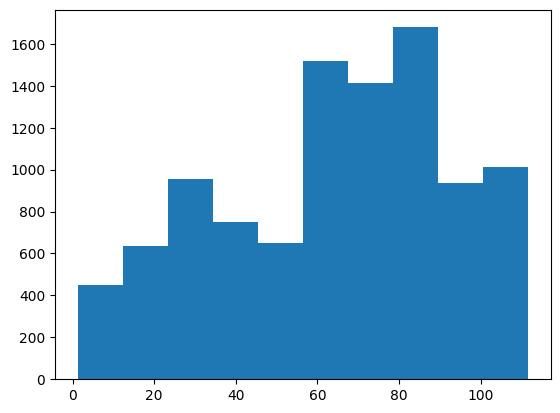

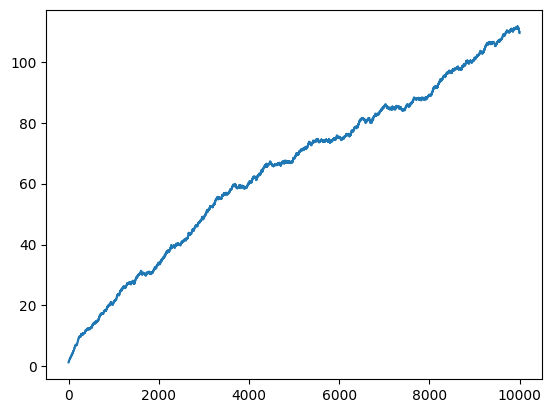

/tmp/ipykernel_6885/2324629769.py:61: RuntimeWarning: overflow encountered in exp
  ps+=[float(np.exp(f(s)))]


/home/bmb41/.local/lib/python3.10/site-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


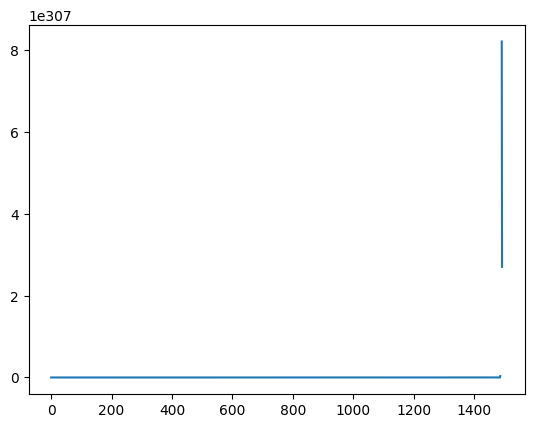

In [43]:
from collections import namedtuple
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC
MHState = namedtuple("MHState", ["u", "rng_key"])
class MetropolisHastings(numpyro.infer.mcmc.MCMCKernel):
    sample_field = "u"

    def __init__(self, potential_fn, step_size=0.1):
        self.potential_fn = potential_fn
        self.step_size = step_size
    def init(self, rng_key, num_warmup, init_params, model_args, model_kwargs):
        
        return MHState(init_params, rng_key)
    def sample(self, state, model_args, model_kwargs):
        u, rng_key = state
        rng_key, key_proposal, key_accept = random.split(rng_key, 3)
        u_proposal = dist.Normal(u, self.step_size).sample(key_proposal)
        accept_prob = jnp.exp(self.potential_fn(u) - self.potential_fn(u_proposal))
        u_new = jnp.where(dist.Uniform().sample(key_accept) < accept_prob, u_proposal, u)
        return MHState(u_new, rng_key)
    
def f(x):
    return ((x - 2) ** 2).sum()




mint=random.uniform(random.PRNGKey(32),(100,))*(21-16)+16

snp= SkewNormalPlus(mint,0.1,21,0.01)

rng=random.PRNGKey(101)
m_s=snp.sample(rng,(1,100))



def model_post(sigma):
    
    return SkewNormalPlus(m_int=mint, sigma_int=sigma,
                                               m_cut=21,sigma_cut=sigma/10).log_prob(m_s).sum()-100*np.exp(10)



kernel = MetropolisHastings(model_post)
mcmc = MCMC(kernel, num_warmup=0, num_samples=10000)
mcmc.run(random.PRNGKey(0), init_params=jnp.array([1.1]))
posterior_samples = mcmc.get_samples()
mcmc.print_summary()

samps = posterior_samples.reshape(10000,)
plt.hist(samps)
plt.show()

plt.plot(samps)
plt.show()
ps= []
for s in samps:
    ps+=[float(np.exp(model_post(s)))]
    
    
    
plt.plot(ps)
    


In [41]:
print(np.exp(1))
print(np.exp(SkewNormalPlus(m_int=mint, sigma_int=0.1,m_cut=21,sigma_cut=0.01).log_prob(m_s).sum()/100)/np.exp(1))

2.718281828459045
0.9282767162903525


1.5746858334646025e+40


In [ ]:
import pickle
import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

@jit
def minmax_fit_and_scale(X):
  max= jnp.max(X,axis=0)
  min = jnp.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max

@jit
def minmax_scale(X,min,max):
  return (X - min) / (max - min)

@jit
def minmax_unscale(X,min,max):
  return X * (max - min) + min

from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Relu, stax.Dense(1024),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun

rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=256,K=20,B=3),)*5),prior=Normal())

_, log_pdf_flow, sample_flow = init_fun(flow_rng,2 )



In [ ]:
file = jnp.load('flow2d2.npz',allow_pickle=True)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)

opt_params = pickle.load(open('flow2d_opt2.pkl', "rb"))
opt_state = optimizers.pack_optimizer_state(opt_params)

params = get_params(opt_state)



min_file = jnp.asarray(file['min'])
max_file = jnp.asarray(file['max'])
diff_scale = jnp.log(max_file[0]-min_file[0])

class FlowSNP(Distribution):
    arg_constraints = {"m_int": constraints.real, "sigma_int": constraints.real,"m_cut": constraints.real, "sigma_cut": constraints.real}
    support = constraints.real
    reparametrized_params = ["m_int", "sigma_int","m_cut","sigma_cut"]

    def __init__(self,m_int,sigma_int,m_cut,sigma_cut,*, validate_args=None,res=1000):


        self.min = min_file
        self.max = max_file




        self.m_int, self.sigma_int,self.m_cut,self.sigma_cut = promote_shapes(m_int,sigma_int,m_cut,sigma_cut)


        batch_shape = lax.broadcast_shapes(jnp.shape(m_int), jnp.shape(sigma_int),jnp.shape(m_int), jnp.shape(sigma_int))

        n_obj = m_int.shape[0]


        self.n_obj=n_obj



        super(FlowSNP, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )


    def sample(self,key, sample_shape=()):
        assert is_prng_key(key)



        no_samps = sample_shape[0]

        self.no_samps = no_samps

        m_col =  jnp.repeat(self.m_int.reshape(self.n_obj),no_samps).reshape(no_samps*self.n_obj,1)

        theta = jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_samps*self.n_obj).reshape(no_samps*self.n_obj,1)))



        samp=sample_flow(key, params,minmax_scale(theta,jnp.asarray(self.min[1:]),np.asarray(self.max[1:])),num_samples=self.no_samps*self.n_obj)

        samp = minmax_unscale(samp[:,0],self.min[0],self.max[0]).reshape(no_samps*self.n_obj,1) + m_col



        return samp.reshape(self.n_obj,self.no_samps).T


    @jit
    def log_prob(self, value):

        if len(value.shape)>1:
            no_samps = value.shape[0]
        else:
            no_samps=1
        no_obj = self.n_obj



        value=value.T.reshape(no_samps*no_obj,)
        value = value.reshape(no_samps*no_obj,1)


        m_col = self.m_int.reshape(no_obj,1)

        theta=jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_obj).reshape(no_obj,1)))

        theta = jnp.repeat(theta,no_samps,axis=0)

        value = value -theta[:,:1]

        X=jnp.asarray(minmax_scale(jnp.column_stack((value,theta)),min_file,max_file))


        prob = log_pdf_flow(params,X)
        prob = prob.reshape(no_obj*no_samps,)
        prob=prob.reshape(no_obj,no_samps).T - diff_scale


        return prob 




In [ ]:





def model(u,m_s=None):

    sigma_int=numpyro.sample('sigma_int',dist.Uniform(0.,0.4))

    with numpyro.plate("plate_i",m_s.shape[0]):
        with numpyro.plate("plate_j",m_s.shape[1]):

            m_s=numpyro.sample("m_s",FlowSNP(m_int=u, sigma_int=sigma_int,
                                               m_cut=21,sigma_cut=0.01), obs=m_s)
            



def model2(u,m_s=None):

    sigma_int=numpyro.sample('sigma_int',dist.Uniform(0.,0.4))

    with numpyro.plate("plate_i",m_s.shape[0]):
        with numpyro.plate("plate_j",m_s.shape[1]):

            m_s=numpyro.sample("m_s",SkewNormalPlus(m_int=u, sigma_int=sigma_int,
                                               m_cut=21,sigma_cut=0.01), obs=m_s)







In [ ]:
from numpyro.infer import init_to_value



sig = [0.05,0.1,0.2,0.3]

rng = random.PRNGKey(54)
print(rng)

for s in sig:


  rng, _ = random.split(rng)



  u=random.uniform(rng,(100,))*(21-16)+16


  rng, _ = random.split(rng)


  snp= SkewNormalPlus(u,s,21,0.01)

  m_s=snp.sample(rng,(1,100))


  nuts_kernel = MetropolisHastings(model2)

    
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  rng, _ = random.split(rng)
    
  print(rng)

  mcmc.run(random.PRNGKey(0),init_params=jnp.array([0.15,0.11,0.33,0.2]),u=u,m_s= m_s)

  mcmc.print_summary()

  samp1=mcmc.get_samples()

  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  nuts_kernel = RandomWalkMetropolis(model2)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  mcmc.run(random.PRNGKey(0),init_params=jnp.array([0.15,0.11,0.33,0.2]),u=u,m_s= m_s)

  mcmc.print_summary()

  samp2=mcmc.get_samples()

  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()
    
  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()


  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()

In [ ]:
from numpyro.infer import init_to_value



sig = [0.05,0.1,0.2,0.3]

rng = random.PRNGKey(0)


for s in sig:


  rng, _ = random.split(rng)



  u=random.uniform(rng,(1000,))*0.5+20.5


  rng, _ = random.split(rng)


  snp= SkewNormalPlus(u,s,21,0.01)

  m_s=snp.sample(rng,(1,1000))


  nuts_kernel = NUTS(model,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  rng, _ = random.split(rng)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp1=mcmc.get_samples()

  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  nuts_kernel = NUTS(model2,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp2=mcmc.get_samples()

  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()
    
  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()


  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()

In [ ]:
from numpyro.infer import init_to_value



sig = [0.05,0.1,0.2,0.3]

rng = random.PRNGKey(0)


for s in sig:


  rng, _ = random.split(rng)



  u=random.uniform(rng,(1000,))*0.2+20.5


  rng, _ = random.split(rng)


  snp= SkewNormalPlus(u,s,21,0.01)

  m_s=snp.sample(rng,(1,1000))


  nuts_kernel = NUTS(model,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  rng, _ = random.split(rng)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp1=mcmc.get_samples()

  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  nuts_kernel = NUTS(model2,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp2=mcmc.get_samples()

  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()
    
  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()


  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()

In [ ]:
from numpyro.infer import init_to_value



sig = [0.05,0.1,0.2,0.3]

rng = random.PRNGKey(0)


for s in sig:


  rng, _ = random.split(rng)



  u=random.uniform(rng,(100,))*0.6+20.5


  rng, _ = random.split(rng)


  snp= SkewNormalPlus(u,s,21,0.01)

  m_s=snp.sample(rng,(1,100))


  nuts_kernel = NUTS(model,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  rng, _ = random.split(rng)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp1=mcmc.get_samples()

  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  nuts_kernel = NUTS(model2,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp2=mcmc.get_samples()

  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()
    
  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()


  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()

In [ ]:
from numpyro.infer import init_to_value



sig = [0.05,0.1,0.2,0.3]

rng = random.PRNGKey(0)


for s in sig:


  rng, _ = random.split(rng)



  u=random.uniform(rng,(100,))*0.5+20.5


  rng, _ = random.split(rng)


  snp= SkewNormalPlus(u,s,21,0.01)

  m_s=snp.sample(rng,(1,100))


  nuts_kernel = NUTS(model,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  rng, _ = random.split(rng)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp1=mcmc.get_samples()

  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  nuts_kernel = NUTS(model2,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp2=mcmc.get_samples()

  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()
    
  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()


  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()

In [ ]:
from numpyro.infer import init_to_value



sig = [0.05,0.1,0.2,0.3]

rng = random.PRNGKey(0)


for s in sig:


  rng, _ = random.split(rng)



  u=random.uniform(rng,(100,))*0.2+20.5


  rng, _ = random.split(rng)


  snp= SkewNormalPlus(u,s,21,0.01)

  m_s=snp.sample(rng,(1,100))


  nuts_kernel = NUTS(model,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  rng, _ = random.split(rng)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp1=mcmc.get_samples()

  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  nuts_kernel = NUTS(model2,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp2=mcmc.get_samples()

  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()
    
  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()


  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()

In [ ]:
from numpyro.infer import init_to_value



sig = [0.05,0.1,0.15,0.2,0.25,0.3]

rng = random.PRNGKey(213)


for s in sig:


  rng, _ = random.split(rng)



  u=random.uniform(rng,(100,))*0.2+20.5


  rng, _ = random.split(rng)


  snp= SkewNormalPlus(u,s,21,0.01)

  m_s=snp.sample(rng,(1,100))


  nuts_kernel = NUTS(model,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  rng, _ = random.split(rng)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp1=mcmc.get_samples()

  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  nuts_kernel = NUTS(model2,adapt_step_size=True)

  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000,num_chains=4)

  mcmc.run(rng, u,m_s= m_s)

  mcmc.print_summary()

  samp2=mcmc.get_samples()

  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()
    
  plt.hist(samp1['sigma_int'],bins=50,histtype='step',color='blue',label='Flow')


  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()


  plt.hist(samp2['sigma_int'],bins=50,histtype='step',color='red',label='Analytical')

  plt.title(r'True $\sigma_{int}$ = ' + str(s))

  plt.xlabel(r'$\sigma_{int}$')
  plt.legend()
  plt.show()